# 统计数据集

In [ ]:
''' 统计单肾CTA数据中皮质+髓质标签的大小范围 '''
import SimpleITK as sitk
from tqdm import tqdm
import pandas as pd

d_l = []
df = pd.read_json('/workspace/dataset/renal_ct/json/rsr_single_kidney_dataset.json')
for index, row in tqdm(df.iterrows()):
    # 筛选所有皮质期且层厚为2.5mm数据
    if row['stage'] == 'pz' and row['slice_thickness'] == 2.5: 
        # 重命名路径
        image_path = row['image_path']
        mask_path = row['mask_path']
        # 字典录入信息
        d = {}
        d['case_name'] = row['case_name']
        d['position'] = row['position']
        d['image_path'] = image_path
        d['mask_path'] = mask_path
        # 读取原标签图像
        mask_itk = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask_itk)
        # 首先合并皮质和髓质标签
        kidney_np = mask_np.copy()
        kidney_np[kidney_np == 1] = 0
        kidney_np[kidney_np == 2] = 1
        kidney_np[kidney_np == 3] = 1
        kidney_itk = sitk.GetImageFromArray(kidney_np)
        # 获得肾部标签定位框
        lssfilter = sitk.LabelShapeStatisticsImageFilter()
        lssfilter.Execute(kidney_itk)
        bbox = lssfilter.GetBoundingBox(1)
        x_len = bbox[3]
        y_len = bbox[4]
        z_len = bbox[5]
        d['x_len'] = x_len
        d['y_len'] = y_len
        d['z_len'] = z_len
        d_l.append(d)
# 保存json
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rsr_pz.json')

In [19]:
df = pd.read_json('/workspace/data/rl/json/rsr_pz.json')
df.describe()

,x_len,y_len,z_len
count,613.000000,613.000000,613.000000
mean,91.660685,88.504078,40.411093
std,11.510823,14.344458,4.033440
min,63.000000,60.000000,24.000000
25%,84.000000,78.000000,38.000000
50%,92.000000,87.000000,40.000000
75%,99.000000,97.000000,43.000000
max,153.000000,150.000000,55.000000


# 制作数据集

## 方法1：标签去除主动脉，图像和标注都根据统一框裁剪

In [10]:
''' 将image、mask裁剪至(160,160,64)并只保留血管标签,将路径录入json '''
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import pandas as pd
import random

d_l = []
df = pd.read_json('/workspace/dataset/renal_ct/json/rsr_single_kidney_dataset.json')
for index, row in tqdm(df.iterrows()):
    # 筛选所有皮质期且层厚为2.5mm数据
    if row['stage'] == 'pz' and row['slice_thickness'] == 2.5: 
        # 重命名路径
        image_path = row['image_path']
        mask_path = row['mask_path']
        # 设置新路径
        new_image_dir = '/workspace/data/rl/image/'
        new_mask_dir = '/workspace/data/rl/mask/'
        new_image_path = new_image_dir + image_path.split('/')[-1]
        new_mask_path = new_mask_dir + mask_path.split('/')[-1]
        # 字典录入信息
        d = {}
        d['dataset'] = 'train' # 先全部赋值为训练集
        d['case_name'] = row['case_name']
        d['position'] = row['position']
        d['image_path'] = new_image_path
        d['mask_path'] = new_mask_path
        # 读取原标签图像
        mask_itk = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask_itk)
        # 首先通过肾部标签确定切割点位
        kidney_np = mask_np.copy()
        kidney_np[kidney_np == 1] = 0
        kidney_np[kidney_np == 2] = 1
        kidney_np[kidney_np == 3] = 1
        kidney_itk = sitk.GetImageFromArray(kidney_np)
        # 获得肾部标签定位框
        lssfilter = sitk.LabelShapeStatisticsImageFilter()
        lssfilter.Execute(kidney_itk)
        bbox = lssfilter.GetBoundingBox(1)
        # 根据定位框中点计算切割点位
        x1 = bbox[0] + bbox[3] // 2 - 80
        y1 = bbox[1] + bbox[4] // 2 - 80
        z1 = bbox[2] + bbox[5] // 2 - 32
        x2 = 210 - (bbox[0] + bbox[3] // 2 + 80)
        y2 = 300 - (bbox[1] + bbox[4] // 2 + 80)
        z2 = mask_itk.GetDepth() - (bbox[2] + bbox[5] // 2 + 32)
        # 对于超出范围的切割点进行调整
        if x1 < 0:
            x2 += x1
            x1 = 0
        if x2 < 0:
            x1 += x2
            x2 = 0
        if y1 < 0:
            y2 += y1
            y1 = 0
        if y2 < 0:
            y1 += y2
            y2 = 0
        if z1 < 0:
            z2 += z1
            z1 = 0
        if z2 < 0:
            z1 += z2
            z2 = 0
        # 对image进行切割并保存
        img = sitk.ReadImage(image_path)
        img = sitk.Crop(img, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        sitk.WriteImage(img, new_image_path)
        # 对mask进行切割并只保留血管标签进行保存
        mask_itk = sitk.Crop(mask_itk, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        mask_np = sitk.GetArrayFromImage(mask_itk)
        artery_np = mask_np.copy()
        artery_np[artery_np == 2] = 0
        artery_np[artery_np == 3] = 0
        d['voxel'] = np.sum(artery_np)
        artery_itk = sitk.GetImageFromArray(artery_np)
        artery_itk.SetDirection(mask_itk.GetDirection())
        artery_itk.SetOrigin(mask_itk.GetOrigin())
        artery_itk.SetSpacing(mask_itk.GetSpacing())
        sitk.WriteImage(artery_itk, new_mask_path)
        
        # 统计非严格连通区域（26连通）个数
        ccfilter = sitk.ConnectedComponentImageFilter()
        ccfilter.SetFullyConnected(True)
        output = ccfilter.Execute(artery_itk)
        count = ccfilter.GetObjectCount()
        # 在json中保存统计字典
        d['count'] = count
        
        # 统计严格连通区域（6连通）个数
        ccfilters = sitk.ConnectedComponentImageFilter()
        ccfilters.SetFullyConnected(False)
        output = ccfilters.Execute(artery_itk)
        counts = ccfilters.GetObjectCount()
        # 在json中保存统计字典
        d['counts'] = counts
        
        d_l.append(d)
# 保存json
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl.json')

2508it [06:31,  6.40it/s]


In [12]:
import pandas as pd
pd.set_option('display.max_colwidth',500)    #设置整体宽度
pd.set_option('display.max_rows',100)   #设置最大行数
pd.set_option('display.max_columns', 100) #设置最大列数
df = pd.read_json('/workspace/data/rl/json/rl.json')
# df[(df['count'] == 1) & (df['voxel'] > 3000)]
# df[(df['voxel'] > 3000)]
df[df['counts'] == 1]

,dataset,case_name,position,image_path,mask_path,voxel,count,counts
0,train,wd0038,left,/workspace/data/rl/image/wd0038_pz_l.nii.gz,/workspace/data/rl/mask/wd0038_pz_mask_l.nii.gz,895,1,1
2,train,wd0049,right,/workspace/data/rl/image/wd0049_pz_r.nii.gz,/workspace/data/rl/mask/wd0049_pz_mask_r.nii.gz,1129,1,1
5,train,wd0059,left,/workspace/data/rl/image/wd0059_pz_l.nii.gz,/workspace/data/rl/mask/wd0059_pz_mask_l.nii.gz,390,1,1
7,train,wd0049,left,/workspace/data/rl/image/wd0049_pz_l.nii.gz,/workspace/data/rl/mask/wd0049_pz_mask_l.nii.gz,1048,1,1
8,train,wd0063,right,/workspace/data/rl/image/wd0063_pz_r.nii.gz,/workspace/data/rl/mask/wd0063_pz_mask_r.nii.gz,683,1,1
...,...,...,...,...,...,...,...,...
605,train,wd0792,right,/workspace/data/rl/image/wd0792_pz_r.nii.gz,/workspace/data/rl/mask/wd0792_pz_mask_r.nii.gz,1321,1,1
606,train,wd0791,left,/workspace/data/rl/image/wd0791_pz_l.nii.gz,/workspace/data/rl/mask/wd0791_pz_mask_l.nii.gz,1667,1,1
608,train,wd0782,left,/workspace/data/rl/image/wd0782_pz_l.nii.gz,/workspace/data/rl/mask/wd0782_pz_mask_l.nii.gz,1234,1,1
610,train,wd0794,left,/workspace/data/rl/image/wd0794_pz_l.nii.gz,/workspace/data/rl/mask/wd0794_pz_mask_l.nii.gz,1016,1,1


### 统计结果
#### 85%小于2000像素，97%小于3000像素
#### 75%只有一个连通区域

## 方法2：标签不去除主动脉，图像和标注都根据各自标签框进行裁剪（后续训练中再进行padding）

In [7]:
''' 分别裁剪image、mask并只保留血管标签,将路径录入json '''
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import pandas as pd

d_l = []
df = pd.read_json('/workspace/dataset/renal_ct/json/single_kidney_dataset.json')
for index, row in tqdm(df.iterrows()):
    # 筛选所有皮质期且层厚为2.5mm数据
    if row['stage'] == 'pz' and row['slice_thickness'] == 2.5: 
        # 重命名路径
        image_path = row['img_path']
        mask_path = row['mask_path']
        # 设置新路径
        new_image_dir = '/workspace/data/rl/image2/'
        new_mask_dir = '/workspace/data/rl/mask2/'
        new_image_path = new_image_dir + image_path.split('/')[-1]
        new_mask_path = new_mask_dir + mask_path.split('/')[-1]
        # 字典录入信息
        d = {}
        d['dataset'] = 'train' # 先全部赋值为训练集
        d['case_name'] = row['case_name']
        d['position'] = row['position']
        d['image_path'] = new_image_path
        d['mask_path'] = new_mask_path
        # 读取原标签图像
        mask_itk = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask_itk)
        # 首先通过肾部标签确定切割点位
        kidney_np = mask_np.copy()
        kidney_np[kidney_np == 1] = 0
        kidney_np[kidney_np == 2] = 1
        kidney_np[kidney_np == 3] = 1
        kidney_itk = sitk.GetImageFromArray(kidney_np)
        # 获得肾部标签定位框
        lssfilter = sitk.LabelShapeStatisticsImageFilter()
        lssfilter.Execute(kidney_itk)
        bbox = lssfilter.GetBoundingBox(1)
        # 根据定位框计算切割点位
        x1 = bbox[0]
        y1 = bbox[1]
        z1 = bbox[2]
        x2 = 210 - (bbox[0] + bbox[3])
        y2 = 300 - (bbox[1] + bbox[4])
        z2 = mask_itk.GetDepth() - (bbox[2] + bbox[5])
        # 对image进行切割并保存
        img = sitk.ReadImage(image_path)
        img = sitk.Crop(img, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        sitk.WriteImage(img, new_image_path)
        # 对mask进行切割并只保留血管标签进行保存
        mask_itk = sitk.Crop(mask_itk, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        mask_np = sitk.GetArrayFromImage(mask_itk)
        artery_np = mask_np.copy()
        artery_np[artery_np == 2] = 0
        artery_np[artery_np == 3] = 0
        # 统计血管像素个数
        d['voxel'] = np.sum(artery_np)
        # 保存新的ikt文件
        artery_itk = sitk.GetImageFromArray(artery_np)
        artery_itk.SetDirection(mask_itk.GetDirection())
        artery_itk.SetOrigin(mask_itk.GetOrigin())
        artery_itk.SetSpacing(mask_itk.GetSpacing())
        sitk.WriteImage(artery_itk, new_mask_path)
        
        # 统计非严格连通区域（26连通）个数
        ccfilter = sitk.ConnectedComponentImageFilter()
        ccfilter.SetFullyConnected(True)
        output = ccfilter.Execute(artery_itk)
        count = ccfilter.GetObjectCount()
        # 在json中保存统计字典
        d['count'] = count
        
        # 统计严格连通区域（6连通）个数
        ccfilters = sitk.ConnectedComponentImageFilter()
        ccfilters.SetFullyConnected(False)
        output = ccfilters.Execute(artery_itk)
        counts = ccfilters.GetObjectCount()
        # 在json中保存统计字典
        d['counts'] = counts
        
        d_l.append(d)
# 保存json
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl2.json')

2508it [06:13,  6.71it/s]


In [9]:
df = pd.read_json('/workspace/data/rl/json/rl2.json')
df[df['counts'] == 1].sort_values('voxel')

,dataset,case_name,position,image_path,mask_path,voxel,count,counts
411,train,wd0645,right,/workspace/data/rl/image2/wd0645_pz_r.nii.gz,/workspace/data/rl/mask2/wd0645_pz_mask_r.nii.gz,238,1,1
540,train,wd0736,right,/workspace/data/rl/image2/wd0736_pz_r.nii.gz,/workspace/data/rl/mask2/wd0736_pz_mask_r.nii.gz,254,1,1
445,train,wd0671,left,/workspace/data/rl/image2/wd0671_pz_l.nii.gz,/workspace/data/rl/mask2/wd0671_pz_mask_l.nii.gz,335,1,1
538,train,wd0735,left,/workspace/data/rl/image2/wd0735_pz_l.nii.gz,/workspace/data/rl/mask2/wd0735_pz_mask_l.nii.gz,344,1,1
481,train,wd0696,left,/workspace/data/rl/image2/wd0696_pz_l.nii.gz,/workspace/data/rl/mask2/wd0696_pz_mask_l.nii.gz,388,1,1
...,...,...,...,...,...,...,...,...
22,train,wd0131,left,/workspace/data/rl/image2/wd0131_pz_l.nii.gz,/workspace/data/rl/mask2/wd0131_pz_mask_l.nii.gz,2978,1,1
359,train,wd0597,left,/workspace/data/rl/image2/wd0597_pz_l.nii.gz,/workspace/data/rl/mask2/wd0597_pz_mask_l.nii.gz,3105,1,1
66,train,wd0314,left,/workspace/data/rl/image2/wd0314_pz_l.nii.gz,/workspace/data/rl/mask2/wd0314_pz_mask_l.nii.gz,3210,1,1
91,train,wd0341,right,/workspace/data/rl/image2/wd0341_pz_r.nii.gz,/workspace/data/rl/mask2/wd0341_pz_mask_r.nii.gz,3321,1,1


## 方法3：标签不去除主动脉，图像和标注都根据统一框裁剪

In [36]:
''' 将image、mask裁剪至(160,160,64)并只保留血管标签,将路径录入json '''
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import pandas as pd
import random

d_l = []
df = pd.read_json('/workspace/dataset/renal_ct/json/single_kidney_dataset.json')
for index, row in tqdm(df.iterrows()):
    # 筛选所有皮质期且层厚为2.5mm数据
    if row['stage'] == 'pz' and row['slice_thickness'] == 2.5: 
        # 重命名路径
        image_path = row['img_path']
        mask_path = row['mask_path']
        # 设置新路径
        new_image_dir = '/workspace/data/rl/image3/'
        new_mask_dir = '/workspace/data/rl/mask3/'
        new_image_path = new_image_dir + image_path.split('/')[-1]
        new_mask_path = new_mask_dir + mask_path.split('/')[-1]
        # 字典录入信息
        d = {}
        d['dataset'] = 'train' # 先全部赋值为训练集
        d['case_name'] = row['case_name']
        d['position'] = row['position']
        d['image_path'] = new_image_path
        d['mask_path'] = new_mask_path
        # 读取原标签图像
        mask_itk = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask_itk)
        # 首先通过肾部标签确定切割点位
        kidney_np = mask_np.copy()
        kidney_np[kidney_np == 1] = 0
        kidney_np[kidney_np == 2] = 1
        kidney_np[kidney_np == 3] = 1
        kidney_itk = sitk.GetImageFromArray(kidney_np)
        # 获得肾部标签定位框
        lssfilter = sitk.LabelShapeStatisticsImageFilter()
        lssfilter.Execute(kidney_itk)
        bbox = lssfilter.GetBoundingBox(1)
        # 根据定位框中点计算切割点位
        x1 = bbox[0] + bbox[3] // 2 - 80
        y1 = bbox[1] + bbox[4] // 2 - 80
        z1 = bbox[2] + bbox[5] // 2 - 32
        x2 = 210 - (bbox[0] + bbox[3] // 2 + 80)
        y2 = 300 - (bbox[1] + bbox[4] // 2 + 80)
        z2 = mask_itk.GetDepth() - (bbox[2] + bbox[5] // 2 + 32)
        # 对于超出范围的切割点进行调整
        if x1 < 0:
            x2 += x1
            x1 = 0
        if x2 < 0:
            x1 += x2
            x2 = 0
        if y1 < 0:
            y2 += y1
            y1 = 0
        if y2 < 0:
            y1 += y2
            y2 = 0
        if z1 < 0:
            z2 += z1
            z1 = 0
        if z2 < 0:
            z1 += z2
            z2 = 0
        # 对image进行切割并保存
        img = sitk.ReadImage(image_path)
        img = sitk.Crop(img, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        sitk.WriteImage(img, new_image_path)
        # 对mask进行切割并只保留血管标签进行保存
        mask_itk = sitk.Crop(mask_itk, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        mask_np = sitk.GetArrayFromImage(mask_itk)
        artery_np = mask_np.copy()
        artery_np[artery_np == 2] = 0
        artery_np[artery_np == 3] = 0
        d['voxel'] = np.sum(artery_np)
        artery_itk = sitk.GetImageFromArray(artery_np)
        artery_itk.SetDirection(mask_itk.GetDirection())
        artery_itk.SetOrigin(mask_itk.GetOrigin())
        artery_itk.SetSpacing(mask_itk.GetSpacing())
        sitk.WriteImage(artery_itk, new_mask_path)
        # 统计连通区域个数
        ccfilter = sitk.ConnectedComponentImageFilter()
        ccfilter.SetFullyConnected(True)
        output = ccfilter.Execute(artery_itk)
        count = ccfilter.GetObjectCount()
        d['count'] = count
        d_l.append(d)
# 保存json
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl3.json')

2508it [06:01,  6.93it/s]


In [47]:
df = pd.read_json('/workspace/data/rl/json/rl3.json')
df[df['voxel'] > 3000]

,dataset,case_name,position,image_path,mask_path,voxel,count
0,train,wd0038,left,/workspace/data/rl/image3/wd0038_pz_l.nii.gz,/workspace/data/rl/mask3/wd0038_pz_mask_l.nii.gz,24026,1
4,train,wd0051,left,/workspace/data/rl/image3/wd0051_pz_l.nii.gz,/workspace/data/rl/mask3/wd0051_pz_mask_l.nii.gz,13519,1
5,train,wd0059,left,/workspace/data/rl/image3/wd0059_pz_l.nii.gz,/workspace/data/rl/mask3/wd0059_pz_mask_l.nii.gz,4200,1
6,train,wd0059,right,/workspace/data/rl/image3/wd0059_pz_r.nii.gz,/workspace/data/rl/mask3/wd0059_pz_mask_r.nii.gz,3089,1
7,train,wd0049,left,/workspace/data/rl/image3/wd0049_pz_l.nii.gz,/workspace/data/rl/mask3/wd0049_pz_mask_l.nii.gz,5748,1
...,...,...,...,...,...,...,...
605,train,wd0792,right,/workspace/data/rl/image3/wd0792_pz_r.nii.gz,/workspace/data/rl/mask3/wd0792_pz_mask_r.nii.gz,5440,2
606,train,wd0791,left,/workspace/data/rl/image3/wd0791_pz_l.nii.gz,/workspace/data/rl/mask3/wd0791_pz_mask_l.nii.gz,4951,1
608,train,wd0782,left,/workspace/data/rl/image3/wd0782_pz_l.nii.gz,/workspace/data/rl/mask3/wd0782_pz_mask_l.nii.gz,16401,1
610,train,wd0794,left,/workspace/data/rl/image3/wd0794_pz_l.nii.gz,/workspace/data/rl/mask3/wd0794_pz_mask_l.nii.gz,11931,1


## 方法4：标签去除主动脉，图像和标注都根据各自标签框进行裁剪（后续训练中再进行padding）

In [40]:
''' 分别裁剪image、mask并只保留血管标签,将路径录入json '''
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import pandas as pd
import random

d_l = []
df = pd.read_json('/workspace/dataset/renal_ct/json/rsr_single_kidney_dataset.json')
for index, row in tqdm(df.iterrows()):
    # 筛选所有皮质期且层厚为2.5mm数据
    if row['stage'] == 'pz' and row['slice_thickness'] == 2.5: 
        # 重命名路径
        image_path = row['image_path']
        mask_path = row['mask_path']
        # 设置新路径
        new_image_dir = '/workspace/data/rl/image4/'
        new_mask_dir = '/workspace/data/rl/mask4/'
        new_image_path = new_image_dir + image_path.split('/')[-1]
        new_mask_path = new_mask_dir + mask_path.split('/')[-1]
        # 字典录入信息
        d = {}
        d['dataset'] = 'train' # 先全部赋值为训练集
        d['case_name'] = row['case_name']
        d['position'] = row['position']
        d['image_path'] = new_image_path
        d['mask_path'] = new_mask_path
        # 读取原标签图像
        mask_itk = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask_itk)
        # 首先通过肾部标签确定切割点位
        kidney_np = mask_np.copy()
        kidney_np[kidney_np == 1] = 0
        kidney_np[kidney_np == 2] = 1
        kidney_np[kidney_np == 3] = 1
        kidney_itk = sitk.GetImageFromArray(kidney_np)
        # 获得肾部标签定位框
        lssfilter = sitk.LabelShapeStatisticsImageFilter()
        lssfilter.Execute(kidney_itk)
        bbox = lssfilter.GetBoundingBox(1)
        # 根据定位框计算切割点位
        x1 = bbox[0]
        y1 = bbox[1]
        z1 = bbox[2]
        x2 = 210 - (bbox[0] + bbox[3])
        y2 = 300 - (bbox[1] + bbox[4])
        z2 = mask_itk.GetDepth() - (bbox[2] + bbox[5])
        # 对image进行切割并保存
        img = sitk.ReadImage(image_path)
        img = sitk.Crop(img, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        sitk.WriteImage(img, new_image_path)
        # 对mask进行切割并只保留血管标签进行保存
        mask_itk = sitk.Crop(mask_itk, lowerBoundaryCropSize=[x1, y1, z1], upperBoundaryCropSize=[x2, y2, z2])
        mask_np = sitk.GetArrayFromImage(mask_itk)
        artery_np = mask_np.copy()
        artery_np[artery_np == 2] = 0
        artery_np[artery_np == 3] = 0
        # 统计血管像素个数
        d['voxel'] = np.sum(artery_np)
        # 保存新的ikt文件
        artery_itk = sitk.GetImageFromArray(artery_np)
        artery_itk.SetDirection(mask_itk.GetDirection())
        artery_itk.SetOrigin(mask_itk.GetOrigin())
        artery_itk.SetSpacing(mask_itk.GetSpacing())
        sitk.WriteImage(artery_itk, new_mask_path)
        # 统计连通区域个数
        ccfilter = sitk.ConnectedComponentImageFilter()
        ccfilter.SetFullyConnected(True)
        output = ccfilter.Execute(artery_itk)
        count = ccfilter.GetObjectCount()
        # 在json中保存统计字典
        d['count'] = count
        d_l.append(d)
# 保存json
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl4.json')

2508it [04:12,  9.92it/s]


In [6]:
df = pd.read_json('/workspace/data/rl/json/rl4.json')
df[(df['count'] == 1)].sort_values('voxel')

,dataset,case_name,position,image_path,mask_path,voxel,count
411,train,wd0645,right,/workspace/data/rl/image4/wd0645_pz_r.nii.gz,/workspace/data/rl/mask4/wd0645_pz_mask_r.nii.gz,238,1
540,train,wd0736,right,/workspace/data/rl/image4/wd0736_pz_r.nii.gz,/workspace/data/rl/mask4/wd0736_pz_mask_r.nii.gz,254,1
412,train,wd0642,left,/workspace/data/rl/image4/wd0642_pz_l.nii.gz,/workspace/data/rl/mask4/wd0642_pz_mask_l.nii.gz,281,1
602,train,wd0789,left,/workspace/data/rl/image4/wd0789_pz_l.nii.gz,/workspace/data/rl/mask4/wd0789_pz_mask_l.nii.gz,323,1
445,train,wd0671,left,/workspace/data/rl/image4/wd0671_pz_l.nii.gz,/workspace/data/rl/mask4/wd0671_pz_mask_l.nii.gz,335,1
...,...,...,...,...,...,...,...
276,train,wd0524,left,/workspace/data/rl/image4/wd0524_pz_l.nii.gz,/workspace/data/rl/mask4/wd0524_pz_mask_l.nii.gz,2911,1
22,train,wd0131,left,/workspace/data/rl/image4/wd0131_pz_l.nii.gz,/workspace/data/rl/mask4/wd0131_pz_mask_l.nii.gz,2978,1
359,train,wd0597,left,/workspace/data/rl/image4/wd0597_pz_l.nii.gz,/workspace/data/rl/mask4/wd0597_pz_mask_l.nii.gz,3105,1
91,train,wd0341,right,/workspace/data/rl/image4/wd0341_pz_r.nii.gz,/workspace/data/rl/mask4/wd0341_pz_mask_r.nii.gz,3321,1


## 方法5：只使用方法1中连通区域为1的数据(26连通)

In [3]:
import pandas as pd
df = pd.read_json('/workspace/data/rl/json/rl.json')
df = df[df['count'] == 1]
df[df['voxel'] < 3000]

,dataset,case_name,position,image_path,mask_path,voxel,count
0,train,wd0038,left,/workspace/data/rl/image/wd0038_pz_l.nii.gz,/workspace/data/rl/mask/wd0038_pz_mask_l.nii.gz,895,1
2,train,wd0049,right,/workspace/data/rl/image/wd0049_pz_r.nii.gz,/workspace/data/rl/mask/wd0049_pz_mask_r.nii.gz,1129,1
3,train,wd0051,right,/workspace/data/rl/image/wd0051_pz_r.nii.gz,/workspace/data/rl/mask/wd0051_pz_mask_r.nii.gz,1139,1
5,train,wd0059,left,/workspace/data/rl/image/wd0059_pz_l.nii.gz,/workspace/data/rl/mask/wd0059_pz_mask_l.nii.gz,390,1
7,train,wd0049,left,/workspace/data/rl/image/wd0049_pz_l.nii.gz,/workspace/data/rl/mask/wd0049_pz_mask_l.nii.gz,1048,1
...,...,...,...,...,...,...,...
606,train,wd0791,left,/workspace/data/rl/image/wd0791_pz_l.nii.gz,/workspace/data/rl/mask/wd0791_pz_mask_l.nii.gz,1667,1
608,train,wd0782,left,/workspace/data/rl/image/wd0782_pz_l.nii.gz,/workspace/data/rl/mask/wd0782_pz_mask_l.nii.gz,1234,1
609,train,wd0794,right,/workspace/data/rl/image/wd0794_pz_r.nii.gz,/workspace/data/rl/mask/wd0794_pz_mask_r.nii.gz,1196,1
610,train,wd0794,left,/workspace/data/rl/image/wd0794_pz_l.nii.gz,/workspace/data/rl/mask/wd0794_pz_mask_l.nii.gz,1016,1


### 统计结果
#### 97.6%小于3000像素（450/461）

In [58]:
# 随机划分测试集
d_l = []
for _, row in df.iterrows():
    d = dict(row)
    d_l.append(d)
random.seed(0)
d_l_test = random.sample(d_l, 92)
for d in d_l_test:
    d['dataset'] = 'test'
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl5.json')

In [21]:
import pandas as pd
df = pd.read_json('/workspace/data/rl/json/rl5.json')
df[df['voxel'] < 500]

,dataset,case_name,position,image_path,mask_path,voxel,count
3,train,wd0059,left,/workspace/data/rl/image/wd0059_pz_l.nii.gz,/workspace/data/rl/mask/wd0059_pz_mask_l.nii.gz,390,1
116,train,wd0385,left,/workspace/data/rl/image/wd0385_pz_l.nii.gz,/workspace/data/rl/mask/wd0385_pz_mask_l.nii.gz,462,1
192,train,wd0481,left,/workspace/data/rl/image/wd0481_pz_l.nii.gz,/workspace/data/rl/mask/wd0481_pz_mask_l.nii.gz,476,1
226,test,wd0539,right,/workspace/data/rl/image/wd0539_pz_r.nii.gz,/workspace/data/rl/mask/wd0539_pz_mask_r.nii.gz,453,1
294,train,wd0625,right,/workspace/data/rl/image/wd0625_pz_r.nii.gz,/workspace/data/rl/mask/wd0625_pz_mask_r.nii.gz,385,1
295,train,wd0625,left,/workspace/data/rl/image/wd0625_pz_l.nii.gz,/workspace/data/rl/mask/wd0625_pz_mask_l.nii.gz,394,1
297,train,wd0628,right,/workspace/data/rl/image/wd0628_pz_r.nii.gz,/workspace/data/rl/mask/wd0628_pz_mask_r.nii.gz,347,1
305,train,wd0631,left,/workspace/data/rl/image/wd0631_pz_l.nii.gz,/workspace/data/rl/mask/wd0631_pz_mask_l.nii.gz,496,1
312,test,wd0645,right,/workspace/data/rl/image/wd0645_pz_r.nii.gz,/workspace/data/rl/mask/wd0645_pz_mask_r.nii.gz,290,1
313,test,wd0642,left,/workspace/data/rl/image/wd0642_pz_l.nii.gz,/workspace/data/rl/mask/wd0642_pz_mask_l.nii.gz,281,1


## 方法6：只使用方法2中连通区域为1的数据（6连通）

In [15]:
import pandas as pd
df = pd.read_json('/workspace/data/rl/json/rl2.json')
df = df[df['counts'] == 1]
df[df['voxel'] < 3000]

,dataset,case_name,position,image_path,mask_path,voxel,count,counts
0,train,wd0038,left,/workspace/data/rl/image2/wd0038_pz_l.nii.gz,/workspace/data/rl/mask2/wd0038_pz_mask_l.nii.gz,845,1,1
2,train,wd0049,right,/workspace/data/rl/image2/wd0049_pz_r.nii.gz,/workspace/data/rl/mask2/wd0049_pz_mask_r.nii.gz,661,1,1
5,train,wd0059,left,/workspace/data/rl/image2/wd0059_pz_l.nii.gz,/workspace/data/rl/mask2/wd0059_pz_mask_l.nii.gz,391,1,1
7,train,wd0049,left,/workspace/data/rl/image2/wd0049_pz_l.nii.gz,/workspace/data/rl/mask2/wd0049_pz_mask_l.nii.gz,864,1,1
9,train,wd0063,left,/workspace/data/rl/image2/wd0063_pz_l.nii.gz,/workspace/data/rl/mask2/wd0063_pz_mask_l.nii.gz,1074,1,1
...,...,...,...,...,...,...,...,...
601,train,wd0787,left,/workspace/data/rl/image2/wd0787_pz_l.nii.gz,/workspace/data/rl/mask2/wd0787_pz_mask_l.nii.gz,1437,1,1
603,train,wd0789,right,/workspace/data/rl/image2/wd0789_pz_r.nii.gz,/workspace/data/rl/mask2/wd0789_pz_mask_r.nii.gz,423,1,1
604,train,wd0792,left,/workspace/data/rl/image2/wd0792_pz_l.nii.gz,/workspace/data/rl/mask2/wd0792_pz_mask_l.nii.gz,1365,1,1
608,train,wd0782,left,/workspace/data/rl/image2/wd0782_pz_l.nii.gz,/workspace/data/rl/mask2/wd0782_pz_mask_l.nii.gz,1200,1,1


### 统计结果
#### 98.7%小于3000像素（295/299）

In [16]:
# 随机划分测试集
d_l = []
for _, row in df.iterrows():
    d = dict(row)
    d_l.append(d)
random.seed(0)
d_l_test = random.sample(d_l, 60)
for d in d_l_test:
    d['dataset'] = 'test'
pd.DataFrame(d_l).to_json('/workspace/data/rl/json/rl6.json')

In [23]:
import pandas as pd
df = pd.read_json('/workspace/data/rl/json/rl6.json')
df

,dataset,case_name,position,image_path,mask_path,voxel,count,counts
0,test,wd0038,left,/workspace/data/rl/image2/wd0038_pz_l.nii.gz,/workspace/data/rl/mask2/wd0038_pz_mask_l.nii.gz,845,1,1
1,train,wd0049,right,/workspace/data/rl/image2/wd0049_pz_r.nii.gz,/workspace/data/rl/mask2/wd0049_pz_mask_r.nii.gz,661,1,1
2,train,wd0059,left,/workspace/data/rl/image2/wd0059_pz_l.nii.gz,/workspace/data/rl/mask2/wd0059_pz_mask_l.nii.gz,391,1,1
3,train,wd0049,left,/workspace/data/rl/image2/wd0049_pz_l.nii.gz,/workspace/data/rl/mask2/wd0049_pz_mask_l.nii.gz,864,1,1
4,train,wd0063,left,/workspace/data/rl/image2/wd0063_pz_l.nii.gz,/workspace/data/rl/mask2/wd0063_pz_mask_l.nii.gz,1074,1,1
...,...,...,...,...,...,...,...,...
294,train,wd0787,left,/workspace/data/rl/image2/wd0787_pz_l.nii.gz,/workspace/data/rl/mask2/wd0787_pz_mask_l.nii.gz,1437,1,1
295,train,wd0789,right,/workspace/data/rl/image2/wd0789_pz_r.nii.gz,/workspace/data/rl/mask2/wd0789_pz_mask_r.nii.gz,423,1,1
296,train,wd0792,left,/workspace/data/rl/image2/wd0792_pz_l.nii.gz,/workspace/data/rl/mask2/wd0792_pz_mask_l.nii.gz,1365,1,1
297,train,wd0782,left,/workspace/data/rl/image2/wd0782_pz_l.nii.gz,/workspace/data/rl/mask2/wd0782_pz_mask_l.nii.gz,1200,1,1


# 训练Landing Spot

In [ ]:
%run train_spot.py

# 预测Landing Spot

In [ ]:
%run pred_spot.py

# PPO算法

In [ ]:
%run train_ppo.py

# 绘制训练log图

In [1]:
# 绘制对比单个log的不同指标
import re
import matplotlib.pyplot as plt

def paint(log_path):
    train_dice_l = []
    val_dice_l = []
    with open(log_path, 'r') as file:
        for line in file:
            train_line = re.search('dice:\s[0]\.[0-9]+$', line)
            if train_line:
                train_dice = re.search('[0]\.[0-9]+', train_line.group())
                if train_dice is not None:
                    train_dice_l.append(float(train_dice.group()))
            else:
                val_line = re.search('dice:\s[0]\.[0-9]+', line)
                if val_line:
                    val_dice = re.search('[0]\.[0-9]+', val_line.group())
                    if val_dice is not None:
                        val_dice_l.append(float(val_dice.group()))
    plt.plot(train_dice_l, 'b')
    plt.plot(val_dice_l, 'r')
    plt.xlabel('count')
    plt.ylabel('dice')
    plt.title('log')
    plt.show()

In [1]:
# 绘制对比不同log的相同指标
import re
import matplotlib.pyplot as plt

def paints(log_paths, option):
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    for i, log_path in enumerate(log_paths):
        l = []
        with open(log_path, 'r') as file:
            for line in file:
                train_line = re.search('dice:\s[0]\.[0-9]+$', line)
                if train_line:
                    train_dice = re.search('[0]\.[0-9]+', train_line.group())
                    if train_dice is not None:
                        if option == 'train':
                            l.append(float(train_dice.group()))
                else:
                    val_line = re.search('dice:\s[0]\.[0-9]+', line)
                    if val_line:
                        val_dice = re.search('[0]\.[0-9]+', val_line.group())
                        if val_dice is not None:
                            if option == 'val':
                                l.append(float(val_dice.group()))
                if option == 'best':
                    best_line = re.search('best\sdice\s[0]\.[0-9]+', line)
                    if best_line:
                        best_dice = re.search('[0]\.[0-9]+', best_line.group())
                        if best_dice is not None:
                            l.append(float(best_dice.group()))
        plt.plot(l, colors[i], label=log_path)
    plt.xlabel('count')
    plt.ylabel('dice')
    plt.title('log')
    plt.legend()
    plt.show()

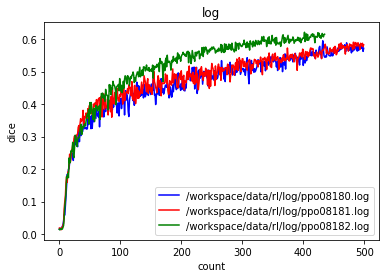

In [4]:
# paints(['/workspace/data/rl/log/ppo08094.log', '/workspace/data/rl/log/ppo08110.log', 
#         '/workspace/data/rl/log/ppo08111.log', '/workspace/data/rl/log/ppo08112.log',
#         '/workspace/data/rl/log/ppo08113.log'], 'train')
# paints(['/workspace/data/rl/log/ppo08094.log', 
#         '/workspace/data/rl/log/ppo08113.log'], 'train')
# paints(['/workspace/data/rl/log/ppo08180.log', '/workspace/data/rl/log/ppo08181.log', 
#         '/workspace/data/rl/log/ppo08182.log', '/workspace/data/rl/log/ppo08210.log',
#         '/workspace/data/rl/log/ppo08211.log'], 'train')
paints(['/workspace/data/rl/log/ppo08180.log', '/workspace/data/rl/log/ppo08181.log',
        '/workspace/data/rl/log/ppo08182.log'], 'train')

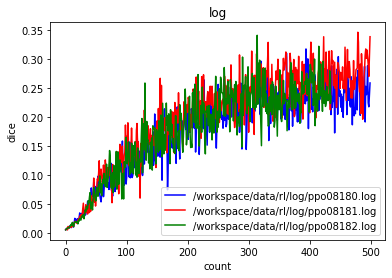

In [5]:
# paints(['/workspace/data/rl/log/ppo08094.log', '/workspace/data/rl/log/ppo08110.log', 
#         '/workspace/data/rl/log/ppo08111.log', '/workspace/data/rl/log/ppo08112.log',
#         '/workspace/data/rl/log/ppo08113.log'], 'val')
# paints(['/workspace/data/rl/log/ppo08094.log', 
#         '/workspace/data/rl/log/ppo08113.log'], 'val')
# paints(['/workspace/data/rl/log/ppo08180.log', '/workspace/data/rl/log/ppo08181.log', 
#         '/workspace/data/rl/log/ppo08182.log', '/workspace/data/rl/log/ppo08210.log',
#         '/workspace/data/rl/log/ppo08211.log'], 'val')
paints(['/workspace/data/rl/log/ppo08180.log', '/workspace/data/rl/log/ppo08181.log',
        '/workspace/data/rl/log/ppo08182.log'], 'val')

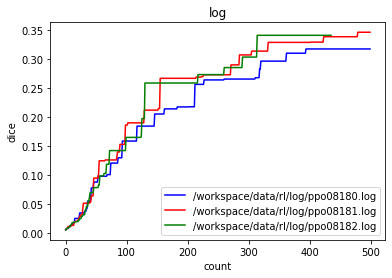

In [6]:
# paints(['/workspace/data/rl/log/ppo08094.log', '/workspace/data/rl/log/ppo08110.log', 
#         '/workspace/data/rl/log/ppo08111.log', '/workspace/data/rl/log/ppo08112.log',
#         '/workspace/data/rl/log/ppo08113.log'], 'best')
paints(['/workspace/data/rl/log/ppo08180.log', '/workspace/data/rl/log/ppo08181.log', 
        '/workspace/data/rl/log/ppo08182.log'], 'best')

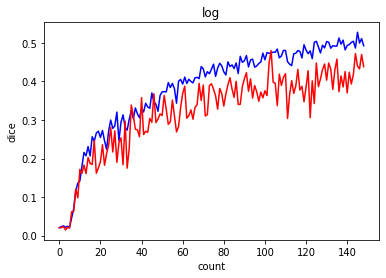

In [8]:
paint('/workspace/data/rl/log/ppo08211.log')